In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import numpy as np 
import scipy.fft
from operators.SW_sqrt import psi_ln_sw
from operators.SW import solve_poisson_equation_two_stream, total_mass, total_momentum, total_energy_k

In [3]:
import matplotlib.pyplot as plt
import matplotlib
from mycolorpy import colorlist as mcp
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

## Manufactured Solution (SW \& SW square-root)

In [4]:
# spatial length
L = 2*np.pi
# number of grid points in space
Nx = 101
# grid spacing
dx = L/(Nx-1)
# final time step
T = 1
# time stepping 
dt = 1e-3
# timestamp vector
t = np.linspace(0, T, int(T/dt)+1)
# velocity parameters sw
u_sw = 1
alpha_sw = np.sqrt(2)
# velocity parameters sw square-root
alpha_swsr = 2
# number of spectral coefficients
Nv = 100
# finite difference order
fd_order = 2

In [5]:
# spatial vector 
x = np.linspace(0, L, Nx)[:-1]
# velocity vector
v = np.linspace(-5, 5, 1001)

In [6]:
# define initial condition
def func_f0(x, v):
    return (np.pi**(-1/4)) * ((2 - np.cos(x))**2)*np.exp(-((v-1)/2)**2)

In [7]:
# get analytic solution at each timestamp
f = np.zeros((len(x), len(v), len(t)))
for ii in range(len(x)):
    for jj in range(len(v)):
        for kk in range(len(t)):
            f[ii, jj, kk] = func_f0(x=x[ii] - v[jj]*t[kk], v=v[jj])

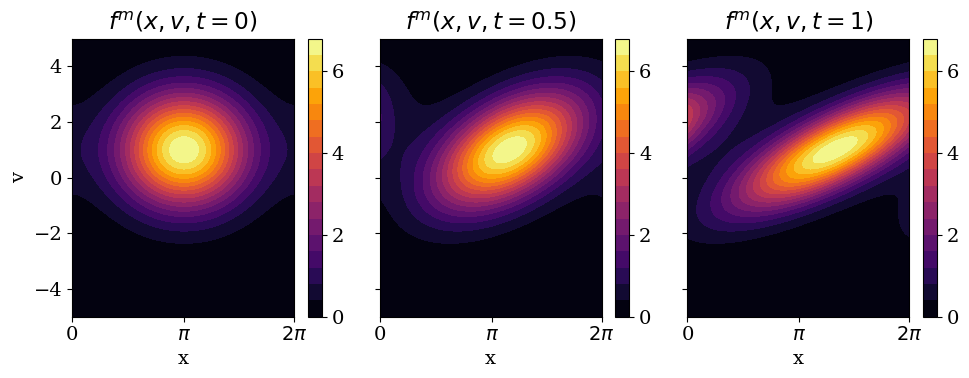

In [8]:
# plot analytic solution 
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(10, 4))
pos = ax[0].contourf(x, v, f[:, :, 0].T,  cmap="inferno", levels=20)
cbar = fig.colorbar(pos)
cbar.ax.set_yticks([0, 2, 4, 6])
pos = ax[1].contourf(x, v, f[:, :, int(len(t)/2)].T,  cmap="inferno", levels=20)
cbar = fig.colorbar(pos)
cbar.ax.set_yticks([0, 2, 4, 6])
pos = ax[2].contourf(x, v, f[:, :, -1].T,  cmap="inferno", levels=20)
cbar = fig.colorbar(pos)
cbar.ax.set_yticks([0, 2, 4, 6])
ax[0].set_title("$f^{m}(x, v, t=0)$")
ax[1].set_title("$f^{m}(x, v, t=0.5)$")
ax[2].set_title("$f^{m}(x, v, t=1)$")
ax[0].set_xticks([0, np.pi, 2*np.pi-dx])
ax[0].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax[1].set_xticks([0, np.pi, 2*np.pi-dx])
ax[1].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax[2].set_xticks([0, np.pi, 2*np.pi-dx])
ax[2].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax[0].set_xlabel("x")
ax[1].set_xlabel("x")
ax[2].set_xlabel("x")
ax[0].set_ylabel("v")
plt.tight_layout()

In [11]:
# load simulation results 
sol_midpoint_sw = np.load("../data/SW/manufactured/manufactured_solution_u_" + str(Nx) + "_FD_" + str(fd_order) + ".npy")
sol_midpoint_swsr = np.load("../data/SW_sqrt/manufactured/manufactured_solution_u_" + str(Nx) + "_FD_" + str(fd_order) + ".npy")

In [12]:
# initialize the states for implicit midpoint (symplectic)
state_e_sw = np.zeros((Nv, Nx-1, len(t)))
state_e_swsr = np.zeros((Nv, Nx-1, len(t)))

for ii, kk in enumerate(np.arange(0, len(t), 1)):
    for jj in range(Nv):
        # unwind the flattening in order to solve the linear system
        state_e_sw[jj, :, ii] = sol_midpoint_sw[jj*(Nx-1): (jj+1)*(Nx-1), kk]
        state_e_swsr[jj, :, ii] = sol_midpoint_swsr[jj*(Nx-1): (jj+1)*(Nx-1), kk]

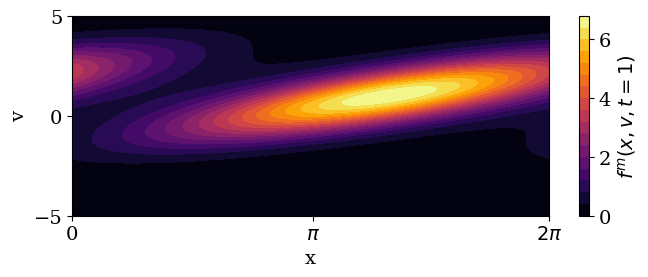

In [13]:
fig, ax = plt.subplots(figsize=(7, 3))
distribution = np.zeros((Nx-1, len(v)))
for jj in range(Nv):
    distribution += np.outer(state_e_sw[jj, :, -1], psi_ln_sw((v-u_sw)/alpha_sw, n=jj))

pos = ax.contourf(x, v, distribution.T, cmap="inferno", levels=20)
cbar = fig.colorbar(pos)
cbar.ax.set_yticks([0, 2, 4, 6])
cbar.ax.set_ylabel(r"$f^{m}(x, v, t=1)$", rotation=90)

ax.set_yticks([-5, 0, 5])
ax.set_xticks([0, np.pi, 2*np.pi-dx])
ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax.set_ylabel("v")
ax.set_xlabel("x")
plt.tight_layout()
plt.savefig("../figs/manufactured/SW/final_snapshot_SW.png", dpi=700)

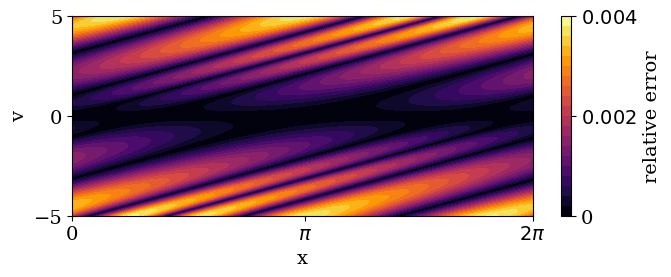

In [14]:
fig, ax = plt.subplots(figsize=(7, 3))
pos = ax.contourf(x, v, np.abs(f[:, :, -1] - distribution).T/f[:, :, -1].T, cmap="inferno", levels=20)
cbar = fig.colorbar(pos)
cbar.ax.set_yticks([0, 0.002,  0.004])
cbar.ax.set_yticklabels(["0", "$0.002$", "$0.004$"])
cbar.ax.set_ylabel(r"relative error", rotation=90)
ax.set_yticks([-5, 0, 5])
ax.set_xticks([0, np.pi, 2*np.pi-dx])
ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax.set_ylabel(r"v")
ax.set_xlabel(r"x")
plt.tight_layout()
plt.savefig("../figs/manufactured/SW/relative_error_SW.png", dpi=700)

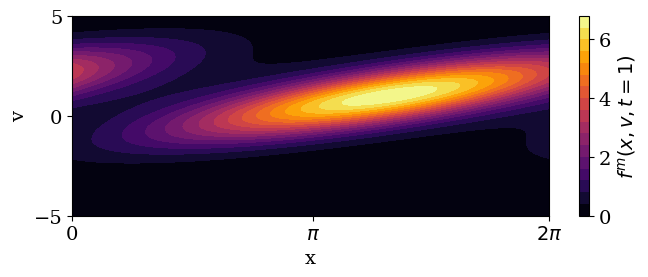

In [15]:
fig, ax = plt.subplots(figsize=(7, 3))
distribution = np.zeros((Nx-1, len(v)))
for jj in range(Nv):
    distribution += np.outer(state_e_swsr[jj, :, -1], psi_ln_sw((v-u_sw)/alpha_swsr, n=jj))

pos = ax.contourf(x, v, (distribution**2).T, cmap="inferno", levels=20)
cbar = fig.colorbar(pos)
cbar.ax.set_yticks([0, 2, 4, 6])
cbar.ax.set_ylabel(r"$f^{m}(x, v, t=1)$", rotation=90)

ax.set_yticks([-5, 0, 5])
ax.set_xticks([0, np.pi, 2*np.pi-dx])
ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax.set_ylabel("v")
ax.set_xlabel("x")
plt.tight_layout()
plt.savefig("../figs/manufactured/SW_sqrt/final_snapshot_SWSR.png", dpi=700)

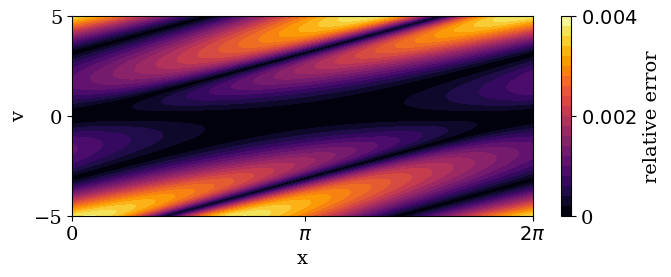

In [16]:
fig, ax = plt.subplots(figsize=(7, 3))
pos = ax.contourf(x, v, np.abs(f[:, :, -1] - distribution**2).T/f[:, :, -1].T, cmap="inferno", levels=20)
cbar = fig.colorbar(pos)
cbar.ax.set_yticks([0, 0.002, 0.004])
cbar.ax.set_yticklabels(["0", "$0.002$", "$0.004$"])
cbar.ax.set_ylabel(r"relative error", rotation=90)
ax.set_yticks([-5, 0, 5])
ax.set_xticks([0, np.pi, 2*np.pi-dx])
ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax.set_ylabel(r"v")
ax.set_xlabel(r"x")
plt.tight_layout()
plt.savefig("../figs/manufactured/SW_sqrt/relative_error_SWSR.png", dpi=700)

In [17]:
mag_coeff_sw_sqrt = np.zeros(Nv)
mag_coeff_sw = np.zeros(Nv)

for ii in range(Nv):
    mag_coeff_sw_sqrt[ii] = np.linalg.norm(state_e_swsr[ii, :, -1], ord=2)
    mag_coeff_sw[ii] = np.linalg.norm(state_e_sw[ii, :, -1], ord=2)

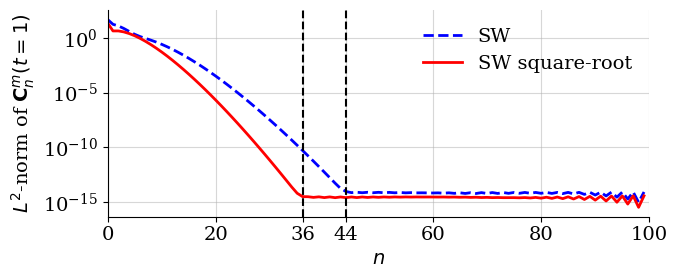

In [20]:
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(np.arange(Nv), mag_coeff_sw, ls="--", linewidth=2, color="blue", label="SW")
ax.plot(np.arange(Nv), mag_coeff_sw_sqrt, linewidth=2, color="red", label="SW square-root")
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axvline(44, color="black", ls="--")
ax.axvline(36, color="black", ls="--")
ax.set_xlabel("$n$")
ax.set_ylabel("$L^2$-norm of $\mathbf{C}_{n}^{m}(t=1)$")
ax.set_yticks([10**0, 10**-5, 10**-10, 10**-15])
ax.set_xlim(0, 100)
ax.set_xticks([0, 20, 36, 44, 60, 80, 100])
legend = ax.legend(ncols=1, loc="upper right")
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig("../figs/manufactured/manufactored_comparison_FD2_Nv.png", dpi=700)

In [21]:
sw_sqrt_FD2 = np.zeros(4)
sw_FD2 = np.zeros(4)

In [22]:
qq = 0
Nv = 100
for pp in [51, 101, 201, 401]:
    Nx = pp
    dx = L/(Nx-1)
    x = np.linspace(0, L, Nx)[:-1]
    f_analytic = np.zeros((len(x), len(v), len(t)))
    for ii in range(len(x)):
        for jj in range(len(v)):
            for kk in range(len(t)):
                f_analytic[ii, jj, kk] = ((2 - np.cos(x[ii] - v[jj]*t[kk]))**2)*(np.pi**(-1/4))*np.exp(-((v[jj] - 1)/2)**2)

    sol_midpoint_u = np.load("../data/SW_sqrt/manufactured/manufactured_solution_u_" + str(Nx) + "_FD_2.npy")
    sol_midpoint_t = np.load("../data/SW_sqrt/manufactured/manufactured_solution_t_" + str(Nx) + "_FD_2.npy")
    #initialize the states 
    state_e_midpoint = np.zeros((Nv, Nx-1))

    for jj in range(Nv):
        # unwind the flattening 
        state_e_midpoint[jj, :] = sol_midpoint_u[jj*(Nx-1): (jj+1)*(Nx-1), -1]

    distribution = np.zeros((Nx-1, len(v)))
    for jj in range(Nv):
        distribution += np.outer(state_e_midpoint[jj, :], psi_ln_sw((v-1)/2, n=jj))
    
    sw_sqrt_FD2[qq] = np.linalg.norm(np.sqrt(dx)*np.abs(distribution[:, :]**2 - f_analytic[:, :, -1]), ord=2)
    
    sol_midpoint_u = np.load("../data/SW/manufactured/manufactured_solution_u_" + str(Nx) + "_FD_2.npy")
    sol_midpoint_t = np.load("../data/SW/manufactured/manufactured_solution_t_" + str(Nx) + "_FD_2.npy")
    #initialize the states 
    state_e_midpoint = np.zeros((Nv, Nx-1))

    for jj in range(Nv):
        # unwind the flattening 
        state_e_midpoint[jj, :] = sol_midpoint_u[jj*(Nx-1): (jj+1)*(Nx-1), -1]

    distribution = np.zeros((Nx-1, len(v)))
    for jj in range(Nv):
        distribution += np.outer(state_e_midpoint[jj, :], psi_ln_sw((v-1)/np.sqrt(2), n=jj))
        
    sw_FD2[qq] = np.linalg.norm(np.sqrt(dx)*np.abs(distribution[:, :] - f_analytic[:, :, -1]), ord=2)
    qq+=1

-1.9952336135028819
-1.9948780976679221


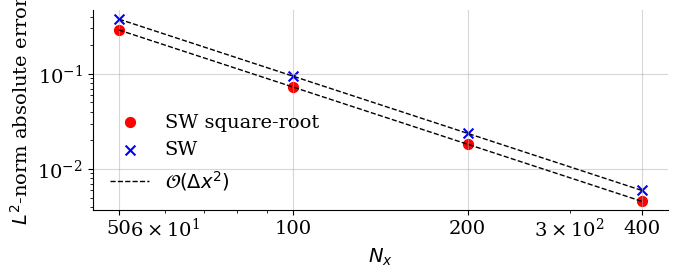

In [24]:
fig, ax = plt.subplots(figsize=(7, 3))

x_axis = np.array([50, 100, 200, 400])

m,b = np.polyfit(np.log(x_axis), np.log(sw_sqrt_FD2), 1)
print(m)
ax.plot(x_axis, np.exp(np.log(x_axis)*m+b), c="black", ls="--", linewidth=1)
ax.scatter(x_axis, sw_sqrt_FD2 , marker="o", color="red", s=50, label="SW square-root")

ax.scatter(x_axis, sw_FD2 , marker="x", color="blue", s=50, label="SW")
m,b = np.polyfit(np.log(x_axis), np.log(sw_FD2), 1)
print(m)
ax.plot(x_axis, np.exp(np.log(x_axis)*m+b), c="black", ls="--", linewidth=1, label="$\mathcal{O}(\Delta x^{2})$")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$L^2$-norm absolute error")
legend = ax.legend(ncols=1, loc="lower left")
legend.get_frame().set_alpha(0)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xticks([])
ax.set_yticks([10**-1, 10**-2])
ax.set_xticks([50, 100, 200, 400])
ax.set_xticklabels([50, 100, 200, 400])

ax.set_xlabel("$N_{x}$")
plt.tight_layout()
plt.grid(alpha=0.5)
plt.savefig("../figs/manufactured/manufactored_comparison_FD2_comparison_correct.png", dpi=700)